# Relax - Future user adoption analysis

We have 2 tables where the data is coming from:
   - Users
   - User engagement with the system
   
Let's load both tables:

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
userDF = pd.read_csv("takehome_users.csv", encoding='1256')
user_engDF = pd.read_csv("takehome_user_engagement.csv")


In [4]:
userDF.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Now, that we have a clear understanding of the structure of both tables we can proceed analysing them.

First, we check how many records we have on each table:

In [5]:
len(userDF), len(user_engDF)

(12000, 207917)

All the user details are stored in 'userDF' table. All interactions of a user with the system are stored in 'user_engDF' table. The definition for an adopted user: __a user who has logged into the product on three separate days in at least one seven-day period__

We should count the number of times a user has logged in for a seven-day period:

In [6]:
# convert time_stamp to datetime type
user_engDF.time_stamp = pd.to_datetime(user_engDF.time_stamp)

# for each user resample the time series to have an entry for each day in the time interval
login_per_day = user_engDF.groupby('user_id').resample('1D', on='time_stamp').count()

In [7]:
# now we can calculate the adopted users by adding a column to users data frame
check_adopt = lambda x: False if (x not in login_per_day.index) else (any(elem > 2 for elem in 
                            login_per_day.loc[x].rolling(7, min_periods=1).sum().visited) ) 

# create the new target column
userDF.loc[:,'adopted'] = userDF.object_id.apply(check_adopt)

We created the target variable 'adopted' that is set to 'True' when a user is adopted and 'False' otherwise. This is a classification task and we need to identify the factors that affect the adoption. Let's check the proportions of the classes:

In [46]:
userDF.adopted.value_counts()

False    10398
True      1602
Name: adopted, dtype: int64

The adopted users make 13% of overall users in our database. This is a dataset with imbalanced number of classes.

Data exploration should be one of the first steps, to identify if there are patterns.

From e-mail field, we can get the domain names:

In [15]:
userDF.email.apply(lambda x: x.split('@')[1]).value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
rerwl.com            2
oqpze.com            2
dqwln.com            2
mumdc.com            2
xvnbr.com            2
qgjbc.com            2
luque.com            2
xybhi.com            2
vkmdh.com            1
xkjnp.com            1
dshfd.com            1
ygefm.com            1
sorsp.com            1
nxcop.com            1
cymqs.com            1
owswg.com            1
ynteo.com            1
fpjbb.com            1
aosyq.com            1
ceneg.com            1
tcenf.com            1
dpqmm.com            1
oswgo.com            1
tfsce.com            1
                  ... 
negte.com            1
wkinn.com            1
iaery.com            1
qmppd.com            1
cxlhf.com            1
tnhyy.com            1
bsmic.com            1
pdwak.com            1
ilfsy.com            1
wdvxb.com            1
curaa.com            1
gblba.com            1
hmohu.com  

We can group the domain names in 7 categories: 'gmail', 'yahoo', 'jourrapide', 'cuvox', 'gustr', 'hotmail' and 'others'.

Will create a new column in dataframe:

In [19]:
domain_dict = {"gmail.com": 0, "yahoo.com": 1, "jourrapide.com": 2, "cuvox.de": 3, "gustr.com": 4, "hotmail.com": 5}

userDF.loc[:, 'domains'] = userDF.email.apply(lambda x: domain_dict[x.split('@')[1]] if (x.split('@')[1] in domain_dict) else 
                                                                                         len(domain_dict) )

We have encoded the domain groups above to ordinal values.

The creation source values are:

In [16]:
userDF.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

We should encode this variable as well:

In [25]:
from sklearn.preprocessing import LabelEncoder

In [29]:
label_enc = LabelEncoder()
userDF.loc[:, 'creation_source_o'] = label_enc.fit_transform(userDF.creation_source)
userDF.creation_source_o.value_counts()

1    4254
0    2163
2    2111
3    2087
4    1385
Name: creation_source_o, dtype: int64

Will check again the dataframe for missing values:

In [31]:
userDF.isnull().any()

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
adopted                       False
domains                       False
creation_source_o             False
dtype: bool

There are 2 columns with missing values: last_session_creation_time, invited_by_user_id

Based on the columns above we will create new columns that check the presence of the values and how they affect the adoption.

In [59]:
userDF.loc[:, 'is_invited'] = userDF.invited_by_user_id.apply(lambda x: np.isnan(x))
userDF.loc[:, 'has_last_session'] = userDF.last_session_creation_time.isnull()

To find the important factors we leverage XGBoost classifier:

In [61]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(userDF[['is_invited', 'domains', 
                'creation_source_o', 'opted_in_to_mailing_list', 
                'enabled_for_marketing_drip', 'org_id']], userDF.adopted.ravel()) #, 'has_last_session'

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

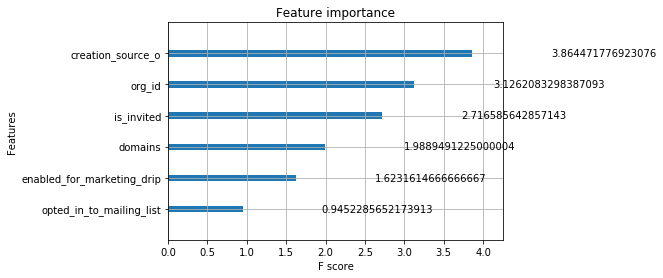

In [62]:
from xgboost import plot_importance
plot_importance(xgb, importance_type='gain')

We have removed the variable 'has_last_session' because we know that whenever it is present, then a user is adopted. 

Checking for the accuracy score:

In [67]:
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy_score(xgb.predict(userDF[['is_invited', 'domains', 
                'creation_source_o', 'opted_in_to_mailing_list', 
                'enabled_for_marketing_drip', 'org_id']]), userDF.adopted)

0.86650000000000005

This score equals the portion of records for the users that are not adopted. There is no predictive power in this model.

We have used the dataset as is. To correct this situation we should oversample the minor class and undersample the major one. We proceed with the following code:

In [70]:
from imblearn.combine import SMOTEENN

smoten = SMOTEENN()

In [84]:
X_resampled, y_resampled =  smoten.fit_sample(userDF[['is_invited', 'domains', 
                'creation_source_o', 'opted_in_to_mailing_list', 
                'enabled_for_marketing_drip', 'org_id']], userDF.adopted)

Now, let's fit the resampled dataset:

In [85]:
xgb.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

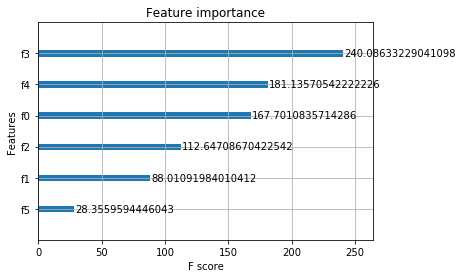

In [86]:
plot_importance(xgb, importance_type='gain')

The results above show that the main 3 factors that affect the user adoption are (in descending order):
  - User opted into marketing e-mailing list
  - User are on the regular marketing e-mail drip
  - Users are invited
  
The factors above are important and there should be taken action on how to leverage those to adopt more users.

For the model above we check again the accuraccy, AUC and F-1 scores:

In [78]:
accuracy_score(xgb.predict(X_resampled), y_resampled)

0.90571559738322049

In [88]:
roc_auc_score(xgb.predict(X_resampled), y_resampled)

0.92974045296743268

In [89]:
from sklearn.metrics import f1_score
f1_score(xgb.predict(X_resampled), y_resampled)

0.86367281475541302

The above scores look much better right now and the prediction power has improved since the previous time.